# The intense drought on the Po river basin in summer 2022

<p align="center">
 <a href="https://www.greenandblue.it/2022/07/04/news/siccita_po_e_altri_fiumi_da_satellite-356491116/">
<img src="./img.png" alt="drought">
 </a>
</p>

The 2022 drought was one of the worst ever recorder on the Po basin.

The event was so severe that it was also reported in international newspapers, such as The Guardian: [Quiet flows the Po: the life and slow death of Italy's longest river](https://www.theguardian.com/environment/2022/jul/10/po-river-italy-drought-climate)

The summer season started with water levels already in deficit due to below average winter and spring precipitation. </br>
I decided that I would check the GloFAS seasonal forecast on the Po river, to see whether some relief was on sight. 

In this notebook I am going to show how easy it is to get data from the CDS to create some nice story.

In [1]:
import climetlab as cml
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import pandas as pd
import seaborn as sbn

In [2]:
# pontelagoscuro
ps = {'name':'pontelagoscuro','lat':44.886111, 'lon':11.604444}

In [7]:
seasonal = cml.load_dataset(
            'cems-glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-08 *',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps], 
            split_on=["month"],
            threads= 9
)

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


In [3]:
water_balance = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            temporal_filter= '2022 01-10 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            # split_on = ['hmonth'],
            # threads = 6
        )

Loading cems config: /home/iacopo/.climetlab/cems_config.json, last modified: 2022-12-31 11:21:34.158314
By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


In [5]:
water_balance.output_names

In [35]:
climatology_2000_2021 = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2000-2021 01-10 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hyear'],
            threads = 21
        )

Let's check where the station is located, and if it is in the correct GloFAS grid cells, so that we know we are getting the river discharge timeseries we wanted.

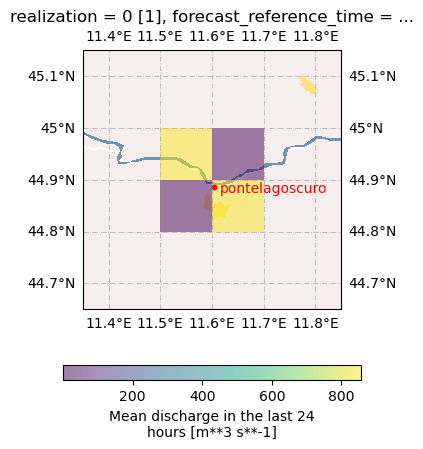

In [5]:
seasonal.show_coords('pontelagoscuro')

In [8]:
seas = seasonal.to_xarray()

In [36]:
seas

<xarray.Dataset>
Dimensions:                  (realization: 51, forecast_reference_time: 8,
                              leadtime: 150, lat: 2, lon: 2)
Coordinates:
  * realization              (realization) int64 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2022-01...
  * leadtime                 (leadtime) timedelta64[ns] 1 days ... 150 days
  * lat                      (lat) float64 44.85 44.95
  * lon                      (lon) float64 11.55 11.65
    time                     (forecast_reference_time, leadtime) datetime64[ns] ...
Data variables:
    dis24                    (realization, forecast_reference_time, leadtime, lat, lon) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-06T16:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [37]:
wb = water_balance.to_xarray()

In [38]:
wbl = wb.sel(latitude=ps['lat'],longitude=ps['lon'], method="nearest")

In [39]:
dfwb = wbl.to_dataframe().reset_index()
dfwb.drop(["latitude", "longitude"], axis=1, inplace=True)
dfwb = dfwb[(dfwb.time.dt.month > 5) & (dfwb.time.dt.month < 10) ]

In [40]:
dfwb['time'] =  pd.DatetimeIndex(dfwb.time)

In [41]:
dfwb

,time,surface,dis24
151,2022-06-01,0.0,2298.031250
152,2022-06-02,0.0,2244.218750
153,2022-06-03,0.0,2158.843750
154,2022-06-04,0.0,2085.500000
155,2022-06-05,0.0,2076.843750
...,...,...,...
268,2022-09-26,0.0,1019.554688
269,2022-09-27,0.0,1000.320312
270,2022-09-28,0.0,979.390625
271,2022-09-29,0.0,956.101562


In [42]:
from datetime  import timedelta

(array([2240., 1936., 1627., 1015.,  421.,  232.,  113.,   47.,   16.,
           3.]),
 array([ 375.65625   , 1042.48120117, 1709.30627441, 2376.13134766,
        3042.95629883, 3709.78125   , 4376.60644531, 5043.43115234,
        5710.25634766, 6377.08105469, 7043.90625   ]),
 <BarContainer object of 10 artists>)

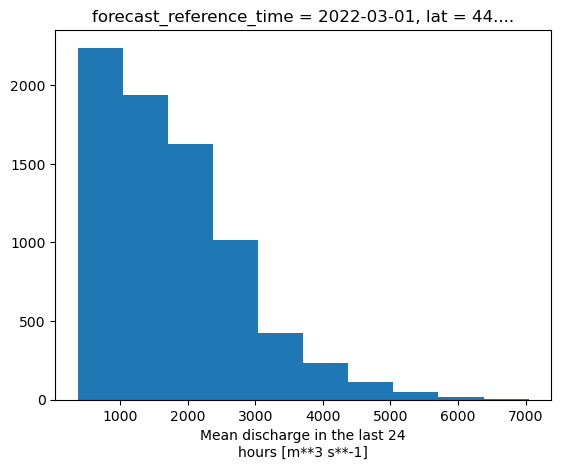

In [78]:
seas.sel(lat=ps['lat'],lon=ps['lon'], forecast_reference_time ="2022-03-01",  method="nearest").dis24.plot.hist()

In [43]:
df = seas.sel(lat=ps['lat'],lon=ps['lon'], method="nearest").to_dataframe() # leadtime=range(0,150,15)

In [44]:
df.drop(['lat','lon'], axis=1, inplace=True)

In [45]:
df2= df.reset_index()

In [46]:
df3 = df2[df2.time.dt.day.isin([1,15,30])]

In [47]:
df3 = df3.drop(["leadtime"], axis= 1)

In [48]:
df3 = df3.loc[(df3.time.dt.month > 5) & ( df3.time.dt.month < 10)]

In [49]:
df3.reset_index(drop=True, inplace=True)

In [50]:
df3['time'] = pd.DatetimeIndex(df3.time)

In [51]:
df3['time'] = df3.time.dt.strftime("%Y-%m-%d")

In [52]:
import matplotlib.dates as mdates

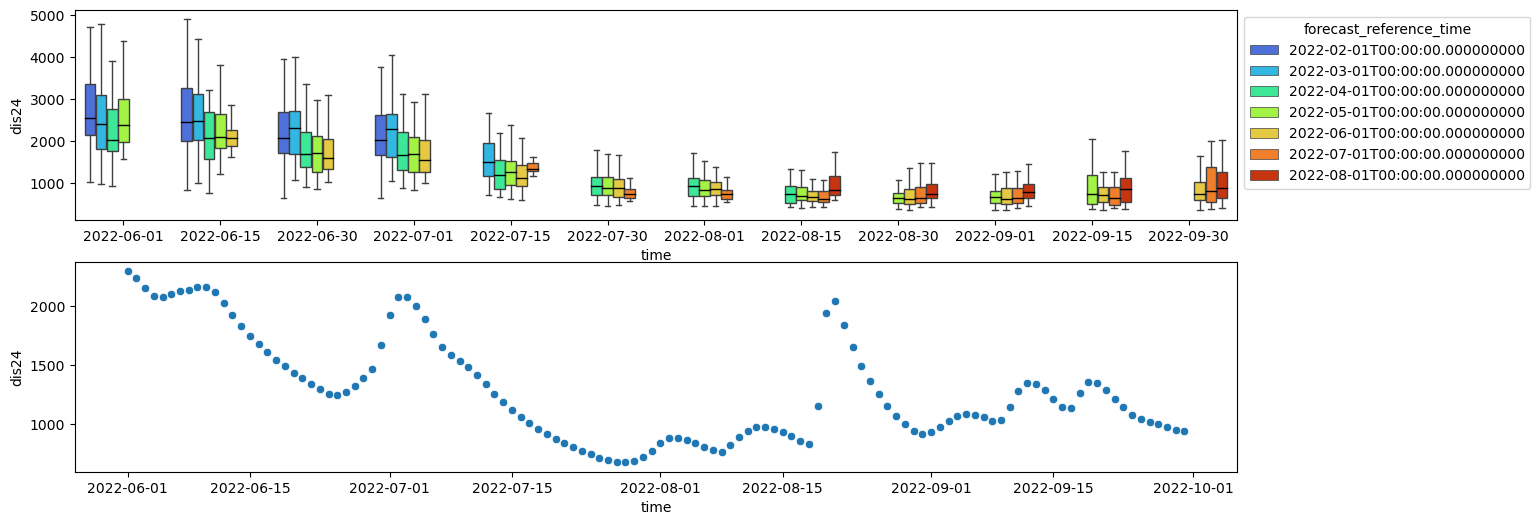

In [58]:
fig, axs =plt.subplots(2,1 ,figsize=(15, 6))
sbn.boxplot(data= df3, x= 'time', y = 'dis24', hue= 'forecast_reference_time',
            ax =axs[0], dodge=True, saturation=0.9, fliersize=1,linewidth=1,medianprops={"color": "black"},
            showfliers=False, palette="turbo")
# axs[0].set_xticks(pd.date_range("2022-06-01","2022-09-30",freq="D"))
# axs[0].set_xticklabels(pd.date_range("2022-06-01","2022-09-30",freq="D").values, rotation=45)
#x_dates = df3.time.dt.strftime("%Y-%m-%d").unique()
#ax.set_xticklabels(x_dates, rotation=45); # ax.get_xticklabels()
sbn.scatterplot(data=dfwb, x= "time", y="dis24", ax= axs[1])
#ax.scatter(dfwb.time, dfwb.dis24)
#ax2.set_xticklabels(dfwb.time.dt.strftime("%Y-%m-%d").values.tolist(), rotation=45)
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
sbn.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))

In [68]:
dx = df3[df3.forecast_reference_time == "2022-06-01"].drop(["realization", "forecast_reference_time"], axis=1)

In [133]:
dxg= dx.groupby("time")
import numpy as np
from matplotlib.dates import num2date, date2num

In [110]:
ex = np.stack([dx.loc[dxg.groups["2022-06-15"]]['dis24'].values, dx.loc[dxg.groups["2022-06-30"]]['dis24'].values]).T

(19144.0, 19173.0)

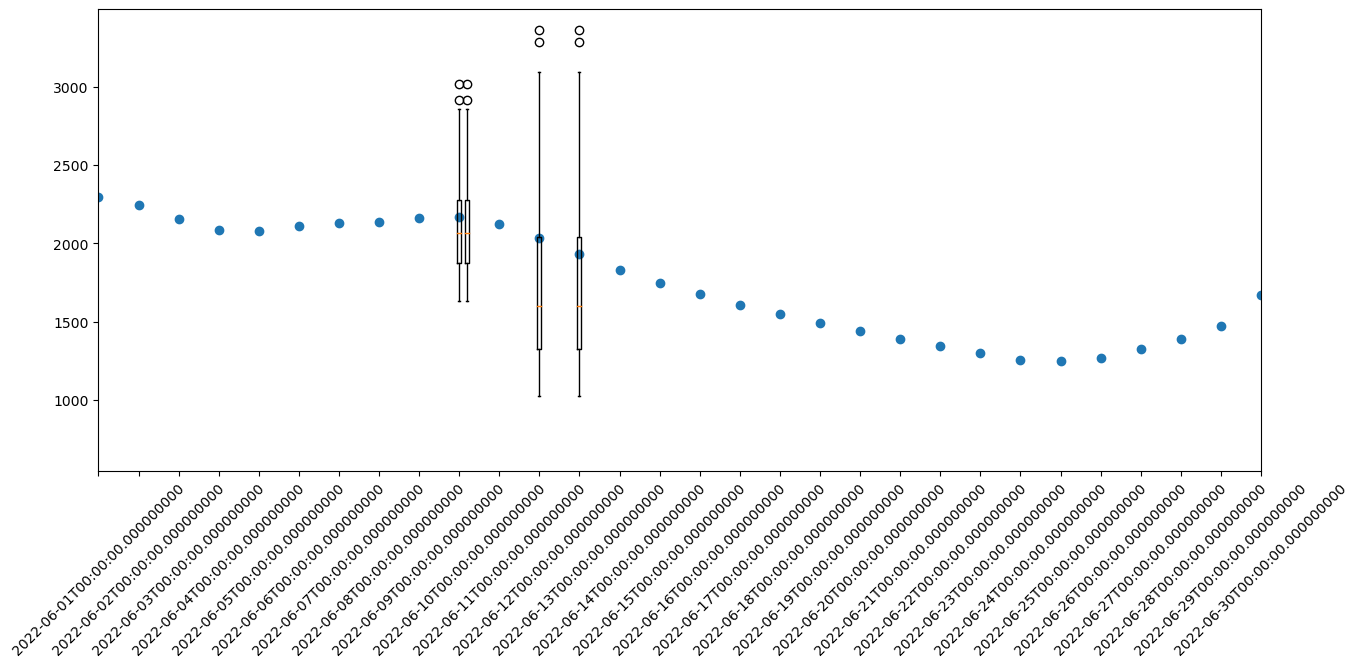

In [150]:
fig, ax = plt.subplots(1,figsize=(15,6))
ax.boxplot(ex, positions=[19153,19155], widths=0.1)
ax.boxplot(ex, positions=[19153.2,19156], widths=0.1)
x_date = pd.date_range("2022-06-01","2022-06-30",freq="D")
x_date = pd.to_datetime(x_date,"%Y-%m-%d")
ax.set_xticks(x_date)
ax.set_xticklabels(x_date.values, rotation=45)
ax.scatter([date2num(i) for i in dfwb.time],dfwb.dis24)
ax.set_xlim([x_date[0], x_date[-1]])

In [122]:
ax.get_xticklabels()

[Text(19144.0, 0, '2022-06-01T00:00:00.000000000'),
 Text(19145.0, 0, '2022-06-02T00:00:00.000000000'),
 Text(19146.0, 0, '2022-06-03T00:00:00.000000000'),
 Text(19147.0, 0, '2022-06-04T00:00:00.000000000'),
 Text(19148.0, 0, '2022-06-05T00:00:00.000000000'),
 Text(19149.0, 0, '2022-06-06T00:00:00.000000000'),
 Text(19150.0, 0, '2022-06-07T00:00:00.000000000'),
 Text(19151.0, 0, '2022-06-08T00:00:00.000000000'),
 Text(19152.0, 0, '2022-06-09T00:00:00.000000000'),
 Text(19153.0, 0, '2022-06-10T00:00:00.000000000'),
 Text(19154.0, 0, '2022-06-11T00:00:00.000000000'),
 Text(19155.0, 0, '2022-06-12T00:00:00.000000000'),
 Text(19156.0, 0, '2022-06-13T00:00:00.000000000'),
 Text(19157.0, 0, '2022-06-14T00:00:00.000000000'),
 Text(19158.0, 0, '2022-06-15T00:00:00.000000000'),
 Text(19159.0, 0, '2022-06-16T00:00:00.000000000'),
 Text(19160.0, 0, '2022-06-17T00:00:00.000000000'),
 Text(19161.0, 0, '2022-06-18T00:00:00.000000000'),
 Text(19162.0, 0, '2022-06-19T00:00:00.000000000'),
 Text(19163.

array([18993., 19024., 19052., 19083., 19113., 19144., 19174., 19205.])

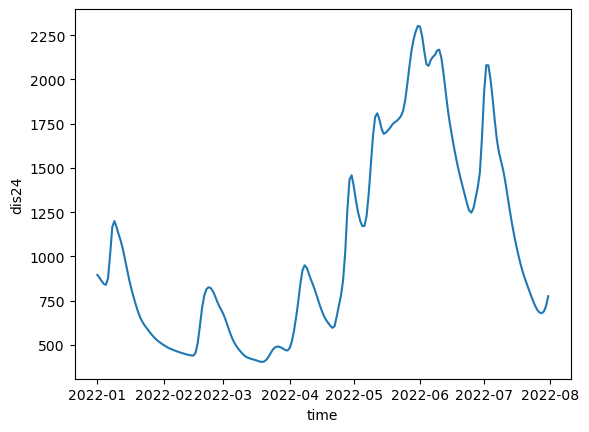

In [212]:
ax2 = sbn.lineplot(data=dfwb, x="time", y= "dis24")
ax2.get_xticks()

<AxesSubplot: xlabel='time', ylabel='dis24'>

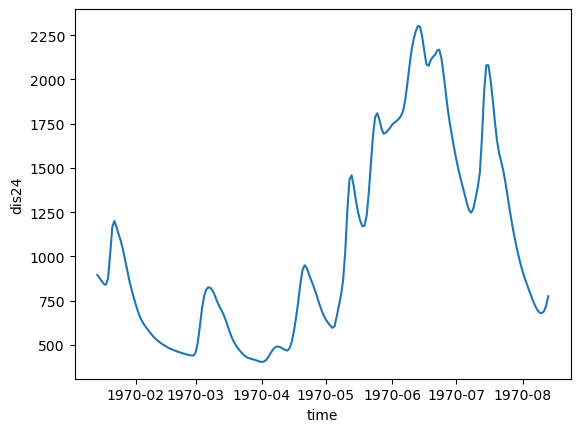

In [113]:
fig.get_axes()[0]

<AxesSubplot: xlabel='time', ylabel='dis24'>

[Text(0, 0, '2022-06-01T00:00:00.000000000'),
 Text(1, 0, '2022-06-15T00:00:00.000000000'),
 Text(2, 0, '2022-06-30T00:00:00.000000000'),
 Text(3, 0, '2022-07-01T00:00:00.000000000'),
 Text(4, 0, '2022-07-15T00:00:00.000000000'),
 Text(5, 0, '2022-07-30T00:00:00.000000000'),
 Text(6, 0, '2022-08-01T00:00:00.000000000'),
 Text(7, 0, '2022-08-15T00:00:00.000000000'),
 Text(8, 0, '2022-08-30T00:00:00.000000000'),
 Text(9, 0, '2022-09-01T00:00:00.000000000'),
 Text(10, 0, '2022-09-15T00:00:00.000000000'),
 Text(11, 0, '2022-09-30T00:00:00.000000000')]

In [584]:
ax.get_xticklabels()

[Text(0, 0, '2022-06-01T00:00:00.000000000'),
 Text(1, 0, '2022-06-15T00:00:00.000000000'),
 Text(2, 0, '2022-06-30T00:00:00.000000000'),
 Text(3, 0, '2022-07-01T00:00:00.000000000'),
 Text(4, 0, '2022-07-15T00:00:00.000000000'),
 Text(5, 0, '2022-07-30T00:00:00.000000000'),
 Text(6, 0, '2022-08-01T00:00:00.000000000'),
 Text(7, 0, '2022-08-15T00:00:00.000000000'),
 Text(8, 0, '2022-08-30T00:00:00.000000000'),
 Text(9, 0, '2022-09-01T00:00:00.000000000'),
 Text(10, 0, '2022-09-15T00:00:00.000000000'),
 Text(11, 0, '2022-09-30T00:00:00.000000000')]

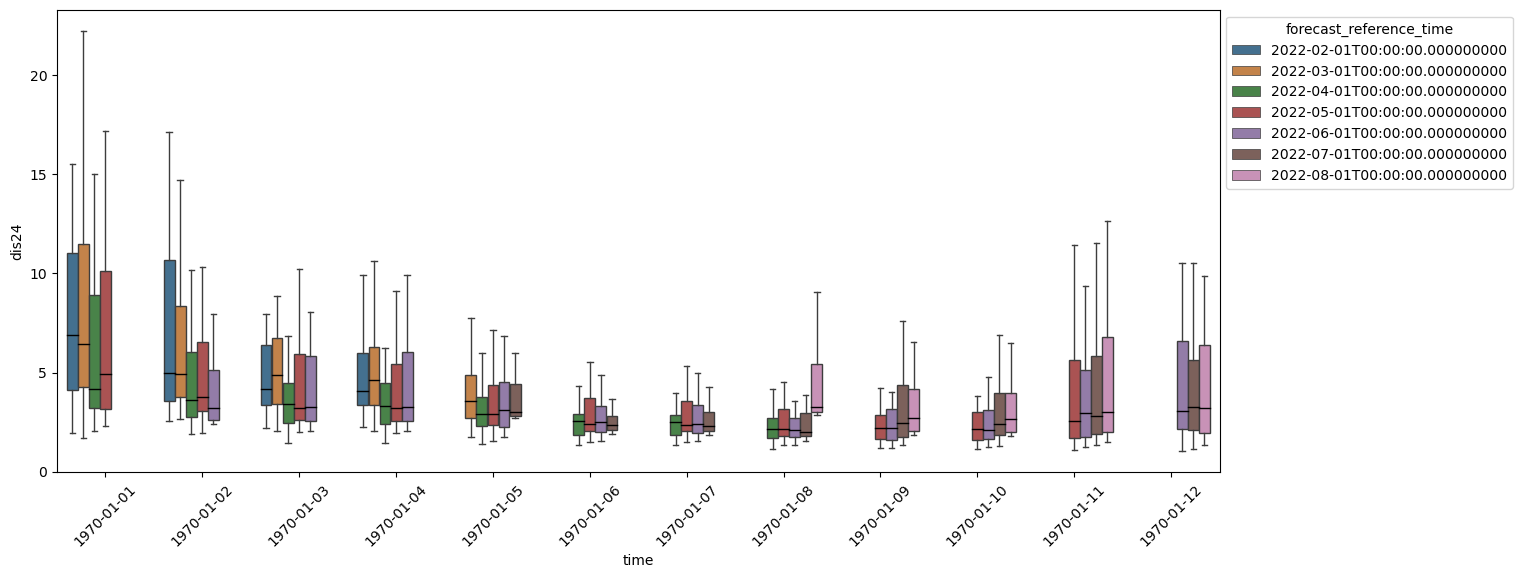

In [536]:
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<AxesSubplot: xlabel='time', ylabel='dis24'>

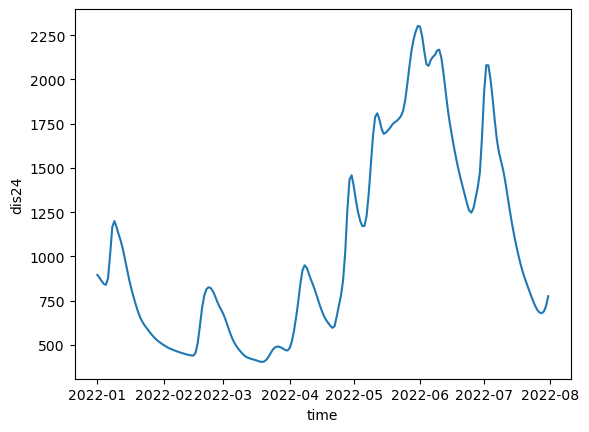

<AxesSubplot: xlabel='time', ylabel='dis24'>

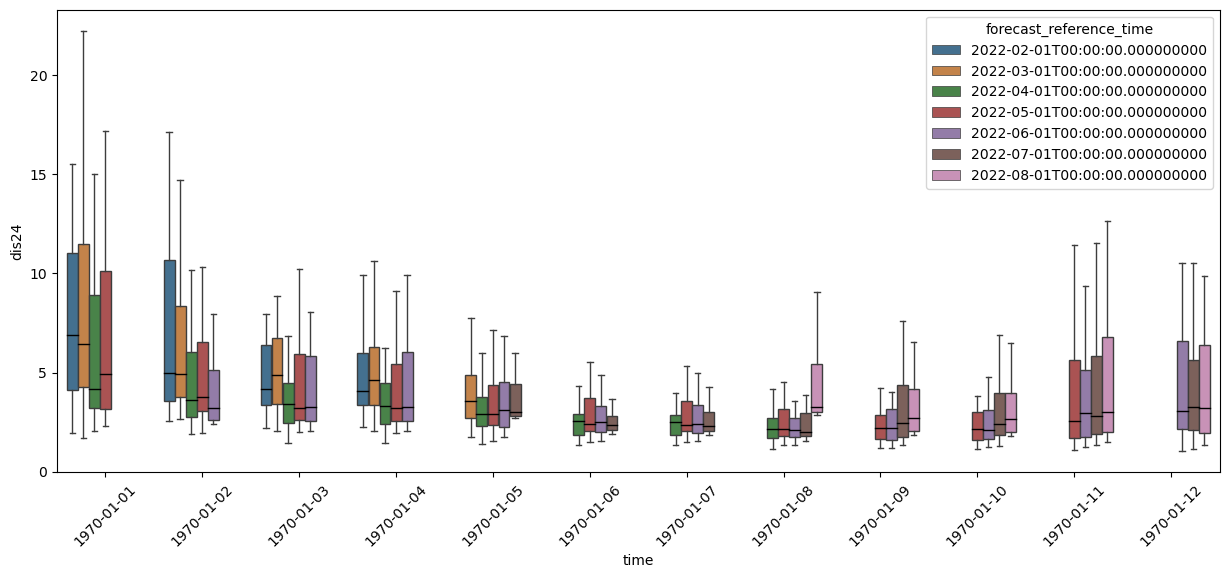

In [497]:
legend.get_legend_handler_map()

{matplotlib.container.StemContainer: <matplotlib.legend_handler.HandlerStem at 0x7f7c0146b9a0>,
 matplotlib.container.ErrorbarContainer: <matplotlib.legend_handler.HandlerErrorbar at 0x7f7c0146bd90>,
 matplotlib.lines.Line2D: <matplotlib.legend_handler.HandlerLine2D at 0x7f7c0146b7f0>,
 matplotlib.patches.Patch: <matplotlib.legend_handler.HandlerPatch at 0x7f7c01433280>,
 matplotlib.patches.StepPatch: <matplotlib.legend_handler.HandlerStepPatch at 0x7f7c01498820>,
 matplotlib.collections.LineCollection: <matplotlib.legend_handler.HandlerLineCollection at 0x7f7c01498880>,
 matplotlib.collections.RegularPolyCollection: <matplotlib.legend_handler.HandlerRegularPolyCollection at 0x7f7c014988e0>,
 matplotlib.collections.CircleCollection: <matplotlib.legend_handler.HandlerCircleCollection at 0x7f7c01498910>,
 matplotlib.container.BarContainer: <matplotlib.legend_handler.HandlerPatch at 0x7f7c01498940>,
 tuple: <matplotlib.legend_handler.HandlerTuple at 0x7f7c014989a0>,
 matplotlib.collection

In [280]:
cl = climatology_2000_2021.to_xarray()

In [107]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

In [108]:
cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True)

In [109]:
cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True)

In [110]:
cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [111]:
cmean

<xarray.Dataset>
Dimensions:    (dayofyear: 304, latitude: 2, longitude: 2)
Coordinates:
  * latitude   (latitude) float64 44.95 44.85
  * longitude  (longitude) float64 11.55 11.65
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 299 300 301 302 303 304 305
Data variables:
    dis24      (dayofyear, latitude, longitude) float32 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-01-04T14:13 GRIB to CDM+CF via cfgrib-0.9.1...

In [114]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")

In [119]:
seas = seas.sel(lat=ps['lat'],lon=ps['lon'],method="nearest")

In [120]:
cmean = cmean.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmax= cmax.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmin = cmin.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

In [127]:
wb = wb.sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

In [ ]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
#plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("Discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [164]:
import numpy as np
from datetime import datetime, timedelta
import seaborn as sbn

In [152]:
dates = [] 
date = datetime(2020, 1, 1)
for i in range(100):
    date =  date + timedelta(days=1)
    dates.append(date)

In [201]:
DI = pd.DatetimeIndex(dates)

In [202]:
df = pd.DataFrame({"date":DI,"realiz_1":np.random.random(100), "realiz_2":np.random.random(100), "realiz_3":np.random.random(100)})

In [169]:
df = df.melt(id_vars="date")

In [181]:
DI_num = [date2num(d) for d in DI]

In [148]:
df['date'] = df['date'].apply(date2num)

In [160]:
ts = np.random.random((10,100))

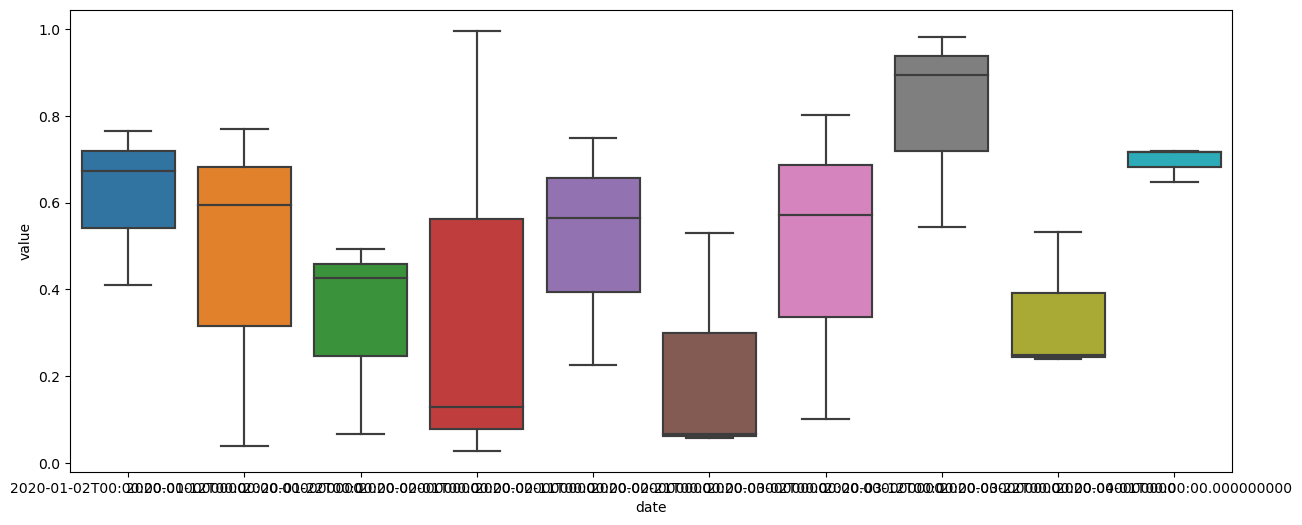

In [200]:
fig, ax = plt.subplots(1, figsize=(15,6))
ax = sbn.boxplot(data=df[::10], x="date", y="value", ax= ax )

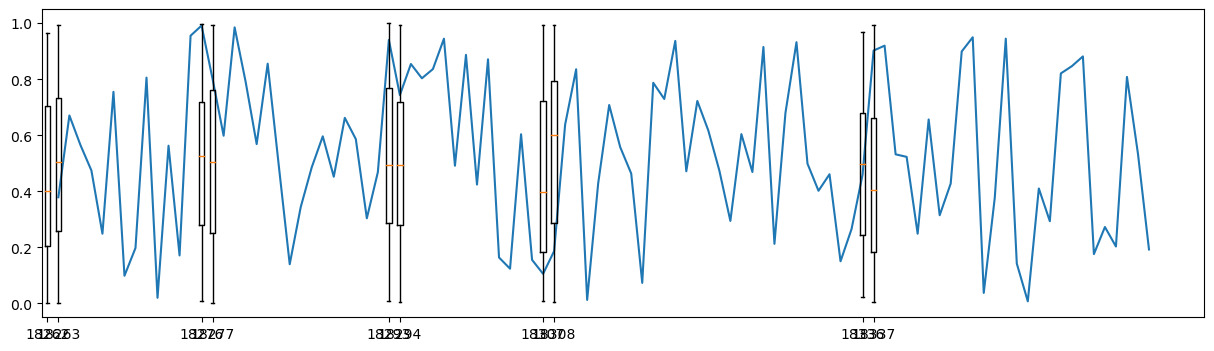

In [224]:
fig, ax = plt.subplots(1, figsize=(15,4))
ax.plot(df['date'], df['realiz_1'])
bplot1 = ax.boxplot(x=np.random.random((100,5)), positions=[18262,18276, 18293,18307,18336])
bplot2 = ax.boxplot(x=np.random.random((100,5)), positions=[18263,18277, 18294,18308,18337])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7bd35d9c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7bd35dad70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7bd35db4f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7bd35da3e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7bd35d9e70>,
 'means': []}

In [212]:
ax.xaxis.get_ticklabels()

[Text(18262.0, 0, '2020-01-01'),
 Text(18276.0, 0, '2020-01-15'),
 Text(18293.0, 0, '2020-02-01'),
 Text(18307.0, 0, '2020-02-15'),
 Text(18322.0, 0, '2020-03-01'),
 Text(18336.0, 0, '2020-03-15'),
 Text(18353.0, 0, '2020-04-01')]

In [144]:
from matplotlib.dates import num2date, date2num

In [145]:
num2date(18262), date2num(df['date'][1])

(datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), 18264.0)

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

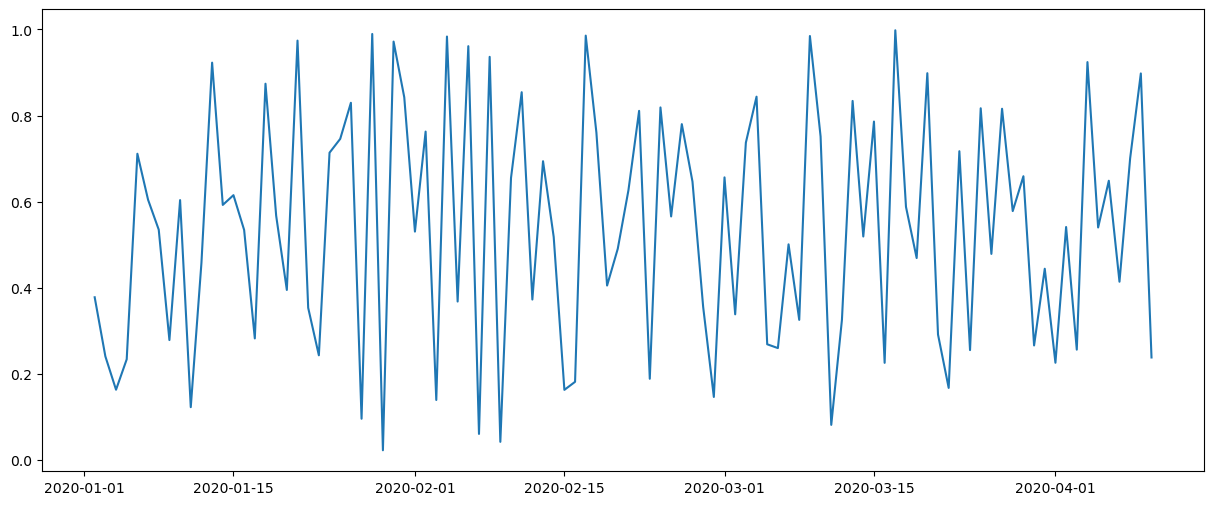

<AxesSubplot: title={'center': 'value'}, xlabel='[date]'>

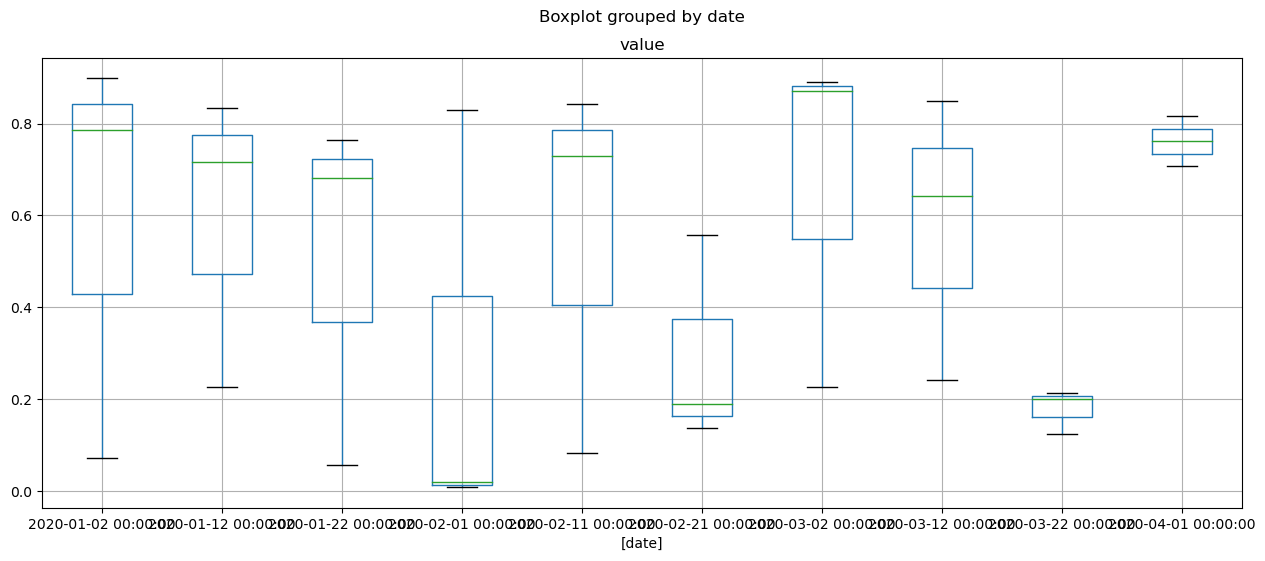

In [90]:
#df.boxplot(by="date", ax=ax)

In [55]:
ts = np.random.random((51, 100)) # realization x leadtime

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

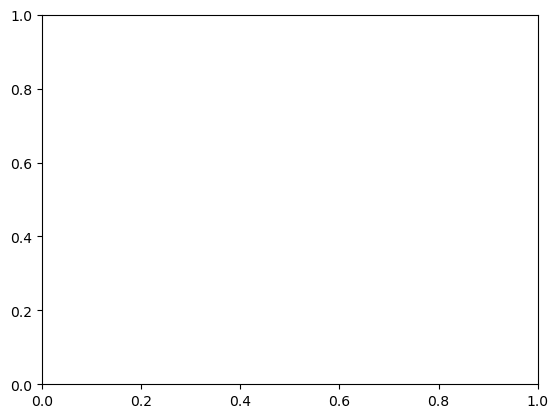

In [56]:
fig, ax = plt.subplots(1)
_ = ax.boxplot(df)

In [25]:
_

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7beed89d50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7beed8a290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7beee287c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7beed8a7d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7beed8aa70>,
 'means': []}